In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [ ]:
#import NVDA ticker data

try:
    nvda_data = yf.download("NVDA", start="2000-01-01", auto_adjust=True, multi_level_index=False)
    
    if nvda_data.empty:
        print("Warning: Downloaded dataframe is empty. Check ticker or connection.")
    else:
        print("Data successfully downloaded.")
        print(nvda_data.head())
except Exception as err:
    print(f"\nError downloading: {err}")


In [ ]:
#flattening of columns to allows for analysis
nvda_data.columns = nvda_data.columns.get_level_values(0)

#Make date a column and not an index 
nvda_data = nvda_data.reset_index()

nvda_data.head()

In [ ]:
#Load and Inspect QQQ data

QQQ_data = pd.read_csv("market_data/QQQ_split_adj.csv")

QQQ_data.head()

In [ ]:
#Data clean up and changing NVDA column names to match QQQ and label prices

nvda_data = nvda_data.rename(columns={
    "Date": "date",
    "Close": "close_NVDA",
    "High": "high_NVDA",
    "Low": "low_NVDA",
    "Open": "open_NVDA",
    "Volume": "volume_NVDA"
    })

#Rename QQQ price columns

QQQ_data = QQQ_data.rename(columns={
    "date": "date",
    "close": "close_QQQ",
    "high": "high_QQQ",
    "low": "low_QQQ",
    "open": "open_QQQ",
    "volume": "volume_QQQ"
    })

#Enforce dateTime object casting
nvda_data['date'] = pd.to_datetime(nvda_data['date'])
QQQ_data['date'] = pd.to_datetime(QQQ_data['date'])

#Filter QQQ data to start from 2000

QQQ_data = QQQ_data[QQQ_data['date'] >= '2000-01-01']

#Drop redundant columns

QQQ_data = QQQ_data.drop(["raw_close", "change_percent", "avg_vol_20d"], axis = 1, errors = 'ignore')

QQQ_data.head()




In [ ]:
#Remove ghost header

nvda_data.columns.name = None
nvda_data.head()

In [ ]:
#Table merging

data_study = pd.merge(nvda_data, QQQ_data, on='date', how='inner')

data_study.head()

In [ ]:
data_study.tail()

In [ ]:
#Reset Index

data_study=data_study.reset_index(drop=True)
data_study.head()

In [ ]:
#check for missng values (NaN)

print(data_study.isnull().sum())

In [ ]:
#Check for duplicates

print(data_study.duplicated().sum())

In [ ]:
#Check Data types

data_study.dtypes

In [ ]:
#Size Inspection
data_study.shape

In [ ]:
#Calculate the percetage change between the current day close and previous close
data_study['NVDA_pct'] = data_study['close_NVDA'].pct_change()
data_study['QQQ_pct'] = data_study['close_QQQ'].pct_change()

data_study.head()

In [ ]:
#Drop initial empty row
data_study = data_study.dropna()

data_study.head()

In [ ]:

#Function to calculate quarterly correlation
def quart_corr(df, asset_col, market_col):
    # Grouping by the actual calendar quarter (Q-DEC means year ends in Dec)
    q_corr = df.groupby(df['date'].dt.to_period('Q')).apply(
    lambda x: x[asset_col].corr(x[market_col])
    )
    
    return q_corr
    

#Regime bar plot function
def plot_regime_bars(df, asset_col, market_col, asset_name="Asset", market_name="Market", title="graphTitle", xTitle = "xlabel", yTitle="yTitle"):
    
    #call quarterly correlation calculator function 
    quarterlyTable = quart_corr(df, asset_col, market_col)
    
    #Get the overall correlation value
    overall_corr_val = df[asset_col].corr(df[market_col])
    # 2. Create the plot
    plt.figure(figsize=(20, 8))

    # Plot the Quarterly Correlation as a Bar Chart
    quarterlyTable.plot(kind='bar', color='lightgray', alpha=0.7, label='Quarterly Regime')

    # Plot the Overall Correlation as a solid Horizontal Line
    plt.axhline(y=overall_corr_val, color='red', linestyle='--', linewidth=2, label=f'24-Year Average ({overall_corr_val:.2f})')

    # Customizing the look
    plt.title(title, fontsize=14)
    plt.ylabel(xTitle)
    plt.xlabel(yTitle)
    plt.legend()
    plt.xticks(rotation=(90), fontsize = 8)
    plt.show()

    
plot_regime_bars(data_study, "NVDA_pct", "QQQ_pct", "NVIDIA", "NASDAQ", 'NVDA vs QQQ: Identifying Regime Deviations', 'Correlation Coefficient', 'Quarter') 

In [ ]:
#Group daily returns by quarters
q_percentent = data_study.groupby(data_study['date'].dt.to_period('Q')).apply(lambda g: g[['NVDA_pct','QQQ_pct']].sum())
#change the quarter index to a string
q_percentent.index = q_percentent.index.astype(str)

#function to plot quarterly trend of QQQ and NVDA
def plot_quarterly_trends(stats_df, asset_col, market_col, title="Quarterly Performance"):
    
    plt.figure(figsize=(14, 6))
    
    sns.lineplot(data=stats_df, x=stats_df.index, y=asset_col, label=asset_col, marker='o')
    sns.lineplot(data=stats_df, x=stats_df.index, y=market_col, label=market_col, marker='s')
    
    plt.title(title, fontsize=14)
    plt.ylabel("Total Quarterly Return (%)")
    plt.xlabel("Quarter")
    plt.xticks(rotation=90, fontsize=8) 
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

#call quarterly trend plot
plot_quarterly_trends(q_percentent, "NVDA_pct", "QQQ_pct", title="Quarterly Total Returns: NVDA vs QQQ (2000-2024)")




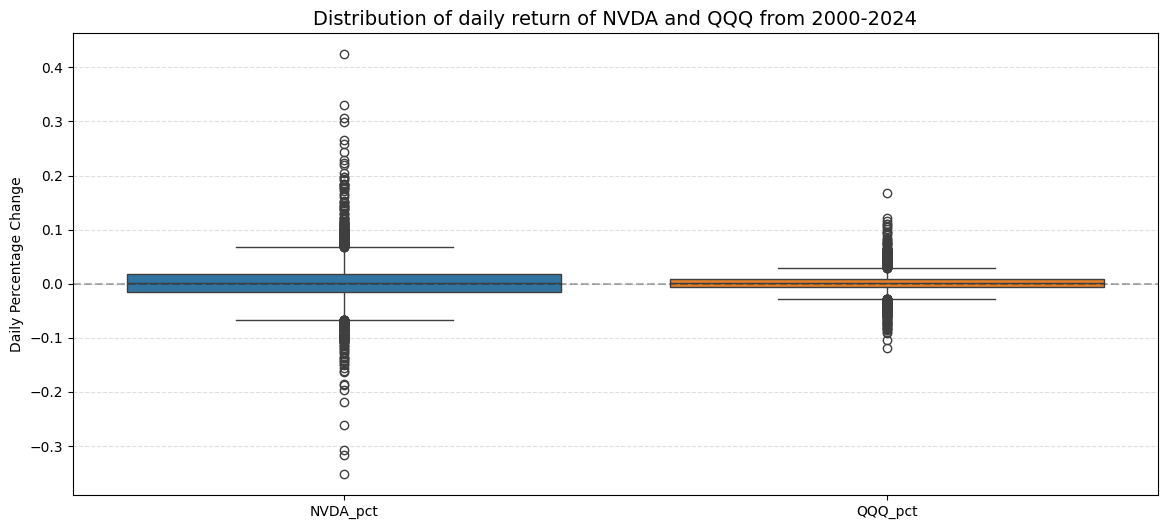

In [58]:
#Box plot to show the spread of volatiliy in both assets
def plot_volatility_spread(df, cols, title):
    plt.figure(figsize=(14, 6))
    
    sns.boxplot(df[cols])
    
    plt.title(title, fontsize=14)
    plt.ylabel("Daily Percentage Change")
    plt.axhline(0, color='black', linestyle='--', alpha=0.3) 
    plt.grid(axis='y', linestyle='--', alpha=0.4)

plot_volatility_spread(data_study ,["NVDA_pct", "QQQ_pct"], "Distribution of daily return of NVDA and QQQ from 2000-2024")
    
    



The box plot confirms that while the median daily return for both assets is near 0%, NVIDIA exhibits significantly higher dispersion (volatility) and more frequent extreme price events (outliers) compared to the QQQ index. This justifies the need for a rolling correlation analysis to see how these extreme moves align with the broader market."

In [62]:
print(data_study[['NVDA_pct', 'QQQ_pct']].describe())

          NVDA_pct      QQQ_pct
count  6108.000000  6108.000000
mean      0.001824     0.000394
std       0.037520     0.017125
min      -0.352336    -0.119788
25%      -0.015806    -0.006617
50%       0.001280     0.000976
75%       0.017869     0.007945
max       0.424147     0.168421


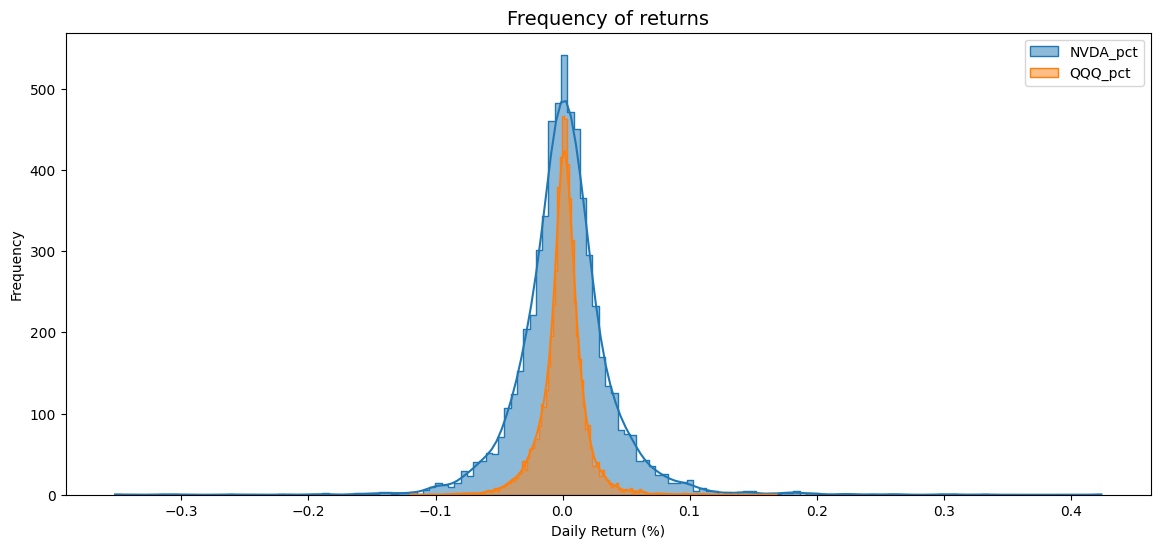

In [68]:
#Histogram to show the shape of the risk

def plot_risk_shape(df, cols, title):
    
    plt.figure(figsize=(14,6))
    for col in cols:
        sns.histplot(df[col], kde=True, element="step", label=col, alpha=0.5)
    
    plt.title(title, fontsize=14)
    plt.xlabel("Daily Return (%)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    
plot_risk_shape(data_study, ["NVDA_pct", "QQQ_pct"], "Frequency of returns")

In [70]:
#Proof that tails exist but are invisible

print("="*70)
print("TAIL EVENT FREQUENCY")
print("="*70)

thresholds = [0.05, 0.10, 0.15, 0.20]

for threshold in thresholds:
    nvda_count = len(data_study[abs(data_study['NVDA_pct']) > threshold])
    qqq_count = len(data_study[abs(data_study['QQQ_pct']) > threshold])
    
    print(f"\nDays with moves > ±{threshold*100:.0f}%:")
    print(f"  NVDA: {nvda_count:3d} days ({nvda_count/len(data_study)*100:.1f}%)")
    print(f"  QQQ:  {qqq_count:3d} days ({qqq_count/len(data_study)*100:.1f}%)")

print("\n These tail events exist but just rare (<<1% of days)")


TAIL EVENT FREQUENCY

Days with moves > ±5%:
  NVDA: 758 days (12.4%)
  QQQ:  118 days (1.9%)

Days with moves > ±10%:
  NVDA: 117 days (1.9%)
  QQQ:   10 days (0.2%)

Days with moves > ±15%:
  NVDA:  42 days (0.7%)
  QQQ:    1 days (0.0%)

Days with moves > ±20%:
  NVDA:  16 days (0.3%)
  QQQ:    0 days (0.0%)

 These tail events exist but just rare (<<1% of days)


NVDA exhibits significantly fatter tails than the broader NASDAQ index (QQQ).
Evidence: While NVDA moves ±5% or more on 12.4% of trading days, QQQ only does so 1.9% of the time—a 6.4x difference. This gap widens at extreme thresholds: NVDA has experienced 16 days with ±20% moves over 24 years, while QQQ has never moved 20% in a single day.
Implication: Standard correlation analysis assumes bivariate normality, which clearly doesn't hold here. This non-normality helps explain why our quarterly correlation varies so much—during extreme NVDA events (which happen regularly), the relationship with QQQ can break down entirely

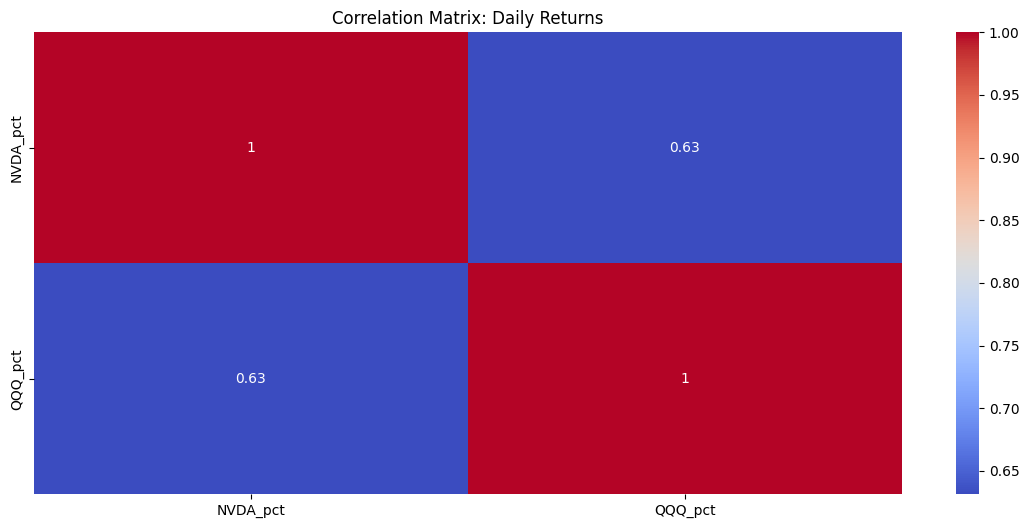

In [71]:
#pearsons correllation matrix
def plot_correlation_matrix(df, cols):
    plt.figure(figsize=(14, 6))
    corr = df[cols].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title("Correlation Matrix: Daily Returns")
    plt.show()

# Execution
plot_correlation_matrix(data_study, ["NVDA_pct", "QQQ_pct"])
    

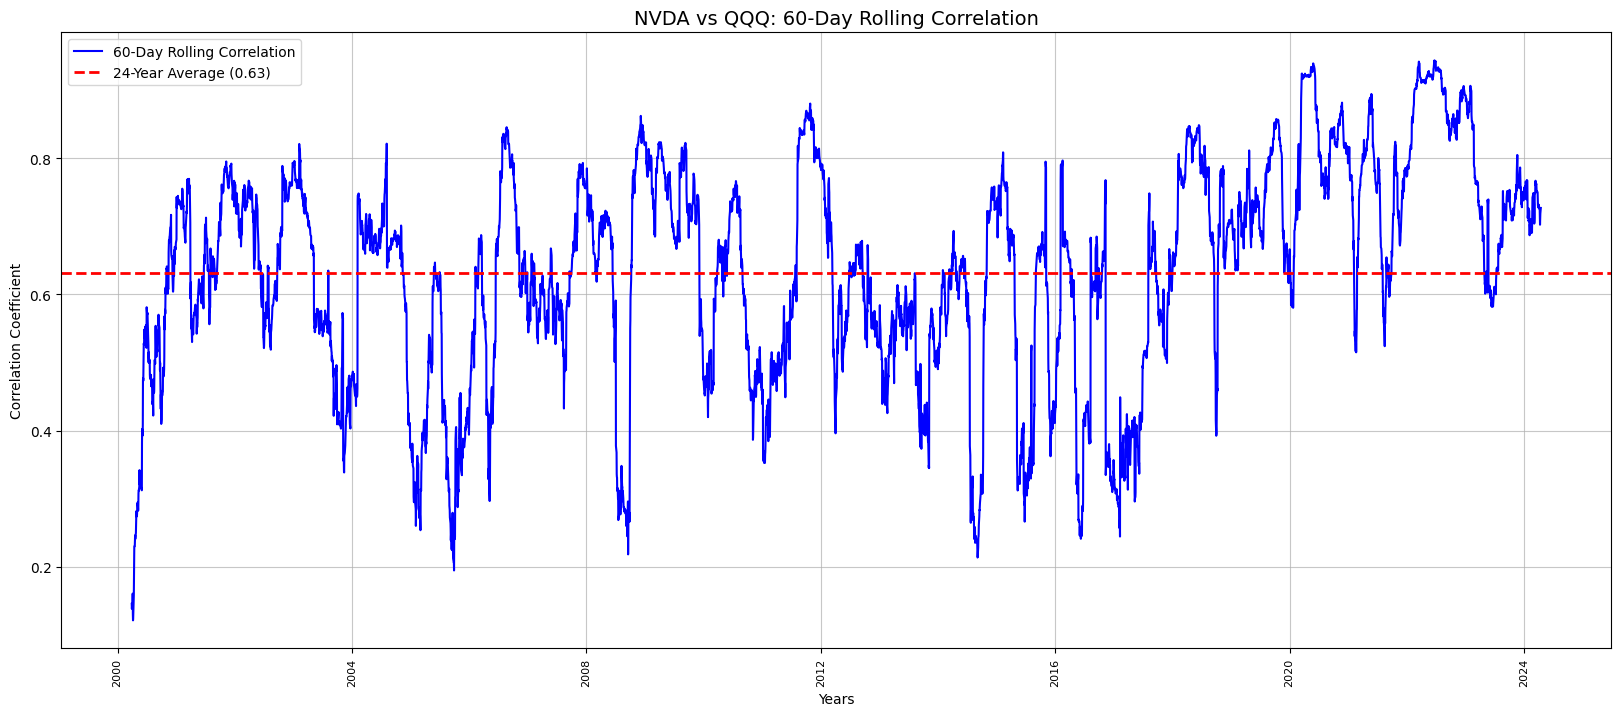

In [75]:

#Function to calculate rolling correlation
def roll_corr(df, asset_col, market_col, window):
    # Grouping by the actual calendar quarter (Q-DEC means year ends in Dec)
    rolling_corr = df[asset_col].rolling(window).corr(df[market_col])
    return rolling_corr
#Function to calculated overall correlation
def get_overall_corr(df, asset_col, market_col):
    return df[asset_col].corr(df[market_col])
    
    

#Regime bar plot function
def plot_regime(df, asset_col, market_col, asset_name="Asset", rwindow=60, title="Regime Analysis"):
    
    #call quarterly correlation calculator function 
    rCorrelation = roll_corr(df, asset_col, market_col, 60)
    baseline = get_overall_corr(df, asset_col, market_col)
  
    plt.figure(figsize=(20, 8))

    # Plot the Quarterly Correlation as a Bar Chart
    plt.plot(df['date'], rCorrelation, label=f'{rwindow}-Day Rolling Correlation', color="blue")

    # Plot the Overall Correlation as a solid Horizontal Line
    plt.axhline(y=baseline, color='red', linestyle='--', linewidth=2, label=f'24-Year Average ({baseline:.2f})')


    plt.grid(True, which='major', linestyle='-', alpha=0.7)
    plt.grid(True, which='minor', linestyle=':', alpha=0.2)
    plt.title(title, fontsize=14)
    plt.ylabel("Correlation Coefficient")
    plt.xlabel("Years")
    plt.legend()
    plt.xticks(rotation=(90), fontsize = 8)
    plt.show()

    
plot_regime(data_study, "NVDA_pct", "QQQ_pct", rwindow=60, title="NVDA vs QQQ: 60-Day Rolling Correlation") 